## Resumo aula 5 de Machine Learning 2 ##

Exemplos de Modelos Não-Supervisionados 

- **Clusterização** - forma de encontrar grupos (clusters) nos dados por meio da comparação de métricas de similaridade, geralmente sendo métricas de "distâncias" em relação de cada ponto em relação ou em relação a uma referência
  - KMeans
  - KMedoids ou KMedians
  - Clusterização Hierárquica

<img src="https://miro.medium.com/max/1838/1*S_Pkf-cK1gUE0OPbDM81ww.png" width=500>

- **Modelos de Densidade** - também é uma forma de agrupamento, porém são mais relacionados à densidade dos pontos numa determinada região do espaço. Geralmente tem uma abordagem probabilística.
  - DBSCAN
  - Modelos de Mistura Gaussiana
- **Redução de dimensionalidade** - importante processo de pré-processamento que visa reduzir o número de dimensões (features) de um dataset. Ao contrário da seleção explítica de atributos, a redução de dimensionalidade atua aplicando uma transformação algébrica na forma de uma combinação dos atributos originais em dimensões menores.
  - PCA
  - Kernel PCA

O **score da silhueta** é uma medida de similaridade de um registro em relação ao seu próprio *cluster* (também conhecido como *coesão*) quando comparado a outros clusters (conhecido como separação). É um valor que varia de -1 a +1, onde valores grandes e positivos apontam que o registro está bem agrupado no cluster apontado e que ele não se adequa bem a nenhum outro cluster vizinho.

Se a grande maior dos scores de silhueta são positivos, então dizemos que a configuração dos agrupamentos é adequada.

<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/67.PNG">

A definição do score de silhueta é:

$$s(i) = \frac{b(i) - a(i)}{\max{[a(i), b(i)]}}$$

Onde $a(i)$ é a distância média do ponto $i$ até todos os pontos **pertencentes ao mesmo cluster ao qual i foi atribuído**; b(i) é a menor distância do ponto $i$ até os pontos dos **outros clusters que não são os mesmos ao qual $i$ foi atribuído**

Mais informações sobre o score de silhueta podem ser encontrados [nesse link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples) e [nesse link](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient).

### Homogeneidade, Complitude e V-Score

Pode acontecer de usarmos as métricas de clusterização para descobrir estruturas de interesse, mesmo quando conhecemos os rótulos dos dados.

Nesse caso, estamos mais interessados em entender as similaridades dos atributos dos registros pertencentes a cada classe do que em classificar os registros propriamente ditos.

A métrica de **homogeneidade** nos diz se cada agrupamento ou cluster contém apenas elementos de uma mesma classe conhecida. É uma forma de analisar a "pureza" da distribuição *intra-cluster*

A métrica de **complitude** nos diz se todos os membros de uma determinada classe foram atribuídos ao mesmo cluster. Nesse caso, estamos analisando a distribuição *inter-cluster*.

A métrica do **V-score** é a média harmônica da homogeneidade e da complitude.

$$v=\frac{(1+\beta)\times h \times c}{\beta h + c}$$

Onde: $\beta$ controla a importância do atributo complitude.

Mais detalhes podem ser vistos [nesse link](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness).

# função para encontrar o número de clusters (método do cotovelo)
def n_clusters(wcss: list):

    # identificar os pontos inicial e final da reta dos extremos
    x1, y1 = 1, wcss[0]
    x2, y2 = len(wcss), wcss[-1]

    # calcular os coeficientes da reta dos extremos
    m = (y2 - y1)/(x2 - x1)
    b = y1 - (m*x1)

    # avaliação das distâncias
    distances = []
    for i in range(len(wcss)):

        x = i+1
        y = wcss[i]

        # definir reta perpendicular à reta dos extremos
        mperp = -m
        bperp = y - (mperp*x)

        # ponto de intersecção (mperp*x_int+b_perp = m*x_int + b)
        x_int = (b - bperp) / (mperp - m)
        y_int = (mperp*x_int) + bperp

        # distância entre os pontos
        dist = np.sqrt(((x-x_int)**2)+((y-y_int)**2))
        distances.append(dist)

    # retorno o número recomendado de clusters
    return distances.index(max(distances))+1

aplicando o método do cotovelo

wcss = []

for i in range(1, 16):

    # definição do modelo
    final_pipe = Pipeline([
        ('preprocessador', pre_processador),
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i))
    ])

    # ajuste do modelo
    final_pipe.fit(x_train)

    # obtenção do WCSS
    wcss.append(final_pipe['kmeans'].inertia_)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.pipeline import Pipeline


In [36]:
data = pd.read_csv('german_credit_data.csv')
data = data.drop(columns='Unnamed: 0', axis=1)
data.Sex = data.Sex.map({'male':'1', 'female':'0'})
x = data.drop(columns='Risk', axis=1)
data.Risk = data.Risk.map({'good': 0, 'bad': 1})
y = data['Risk']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)




num_features = x_train.select_dtypes(include=np.number).columns.tolist()
cat_features =  x_train.select_dtypes(exclude=np.number).columns.tolist()

num_impute = Pipeline([('num_imputer', SimpleImputer(strategy='mean'))])
cat_impute = Pipeline([('cat_imputer', SimpleImputer(strategy='constant',fill_value='unkown')),
                       ('onehot', OneHotEncoder(drop='first'))])

preprocessing = ColumnTransformer([('num_transform', num_impute, num_features),
                                   ('cat_transform', cat_impute, cat_features)], remainder='passthrough')

pipe_final = Pipeline([('preprocess',preprocessing),
                       ('std_scaler',StandardScaler()),
                       ('cluster', KMeans(n_clusters=3))])

pipe_final.fit(x_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='unkown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                           

In [37]:
x_train['cluster'] = pipe_final.predict(x_train)


C:\Users\vitor\AppData\Local\Temp/ipykernel_32756/56449946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['cluster'] = pipe_final.predict(x_train)


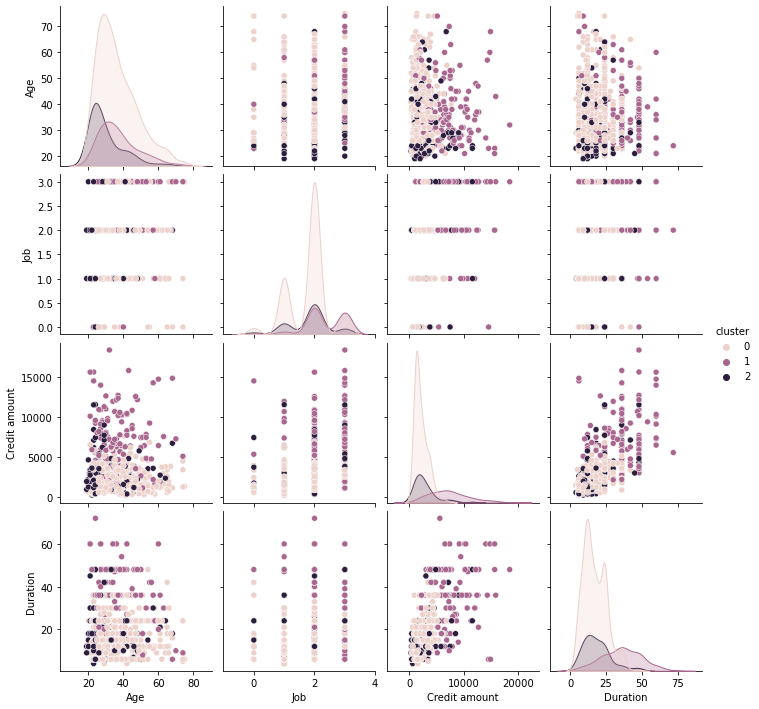

In [38]:
sns.pairplot(x_train, hue='cluster')

c:\Users\vitor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Número recomendado de clusters (método do cotovelo):  9


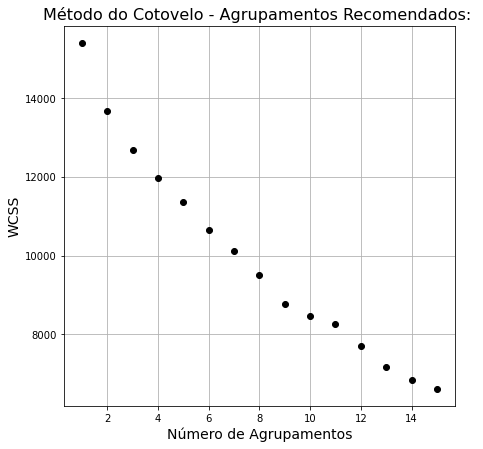

In [39]:
# função para encontrar o número de clusters (método do cotovelo)
def n_clusters(wcss: list):

    # identificar os pontos inicial e final da reta dos extremos
    x1, y1 = 1, wcss[0]
    x2, y2 = len(wcss), wcss[-1]

    # calcular os coeficientes da reta dos extremos
    m = (y2 - y1)/(x2 - x1)
    b = y1 - (m*x1)

    # avaliação das distâncias
    distances = []
    for i in range(len(wcss)):

        x = i+1
        y = wcss[i]

        # definir reta perpendicular à reta dos extremos
        mperp = -m
        bperp = y - (mperp*x)

        # ponto de intersecção (mperp*x_int+b_perp = m*x_int + b)
        x_int = (b - bperp) / (mperp - m)
        y_int = (mperp*x_int) + bperp

        # distância entre os pontos
        dist = np.sqrt(((x-x_int)**2)+((y-y_int)**2))
        distances.append(dist)

    # retorno o número recomendado de clusters
    return distances.index(max(distances))+1

# aplicando o método do cotovelo
wcss = []
for i in range(1, 16):

    # definição do modelo
    final_pipe = Pipeline([
        ('preprocessador', preprocessing),
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i))
    ])

    # ajuste do modelo
    final_pipe.fit(x_train)

    # obtenção do WCSS
    wcss.append(final_pipe['kmeans'].inertia_)
    # determinando o número de clusters
print('Número recomendado de clusters (método do cotovelo): ', n_clusters(wcss))

# construção do gráfico do cotovelo
plt.figure(figsize = (7,7))
plt.plot(range(1, len(wcss)+1), wcss, 'ko')
plt.ylabel('WCSS', size = 14)
plt.xlabel('Número de Agrupamentos', size = 14)
plt.title('Método do Cotovelo - Agrupamentos Recomendados: ', size = 16)
plt.grid(True)